In [1]:
#!pip install pandas
#!pip install tensorflow-gpu
#!pip install matplotlib
#!pip install sklearn

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import vgg16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
## Ref: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE ## Auto tune tf.data hyper parameters for 
## data loading performance
FILE_PATH = '/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data'
#GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * 8#strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# Data Preperation

In [4]:
filenames = tf.io.gfile.glob(str(FILE_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(FILE_PATH + '/chest_xray/val/*/*')))

## since there are 16 images for the validation set, first both train and test sets are
## combined and then the dataset is split with 80, 20 rule (80% training, 20% testing)
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)


In [5]:
# COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
# print("Normal images count in training set: " + str(COUNT_NORMAL))

# COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
# print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))
COUNT_NORMAL = 0
COUNT_BACTERIA = 0
COUNT_VIRUS = 0

for f in train_filenames:
    name = f.split('/')
    if name[-2] == "NORMAL":
        COUNT_NORMAL += 1
    else:
        label = name[-1].split('_')[-2]
        if label == "bacteria":
            COUNT_BACTERIA += 1
        else:
            COUNT_VIRUS += 1

print(COUNT_NORMAL)
print(COUNT_BACTERIA)
print(COUNT_VIRUS)


1083
2029
1073


In [6]:
## put the file names in a tf tensor
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## view few of the file names
for f in train_list_ds.take(5):
    print(f.numpy())

b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/chest_xray/train/NORMAL/IM-0435-0001.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/chest_xray/train/NORMAL/NORMAL2-IM-0667-0001.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/chest_xray/train/PNEUMONIA/person352_bacteria_1625.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/chest_xray/train/PNEUMONIA/person982_bacteria_2909.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/chest_xray/train/PNEUMONIA/person1408_bacteria_3581.jpeg'


In [7]:
## cardinality gives the number of unique elements in the dataset
## Ref: https://orangematter.solarwinds.com/2020/01/05/what-is-cardinality-in-a-database/
## Ref: https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
## View the two classes
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(FILE_PATH + "/chest_xray/train/*"))])
CLASS_NAMES



array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [9]:
## Returns 0 or 1 (False or True) labels
## 1 indicates the Pneumonia class and 0 indicates a Normal class
## label map
keys_tensor = tf.constant(['normal', 'bacteria', 'virus'])
vals_tensor = tf.constant([0, 1, 2])
init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
table = tf.lookup.StaticHashTable(
    init,
    default_value=-1)
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    ## check if pneumonia type or normal 
    if parts[-2] == "NORMAL":
        label = tf.constant('normal')
    else:
        label = tf.strings.split(parts[-1], '_')[-2]
    lbl_idx = table.lookup(label)
    return tf.one_hot(lbl_idx, 3)
    # The second to last is the class-directory
    #return parts[-2] == "PNEUMONIA"

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [11]:
## from a given file path get the label and the corresponding image
def process_path(file_path):
    #print(file_path)
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(AUTOTUNE)

-1


In [13]:
## check the new dataset
for image, label in train_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    #print("File path", fpath.numpy())



Image shape:  (180, 180, 3)
Label:  [1. 0. 0.]
Image shape:  (180, 180, 3)
Label:  [1. 0. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]
Image shape:  (180, 180, 3)
Label:  [0. 0. 1.]
Image shape:  (180, 180, 3)
Label:  [0. 1. 0.]


In [14]:
## Prepare a test dataset for validating the model performances after training
test_list_ds = tf.data.Dataset.list_files(str(FILE_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [15]:
## For caching, repeat, and prefetch, please refer to
## Ref: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str): ## if caching to a file
            ds = ds.cache(cache)
        else: ## cache in memory
            ds = ds.cache()
    ## shuffle data, otherwise, data will be cached with the same patten (not random)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
## prepare the dataset for training
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [17]:
## show sample batch of images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if tf.math.argmax(label_batch[n]).numpy() == 1:
            plt.title("BACTERIA")
        elif tf.math.argmax(label_batch[n]).numpy() == 2:
            plt.title("VIRUS")
        else:
            plt.title("NORMAL")
        plt.axis("off")

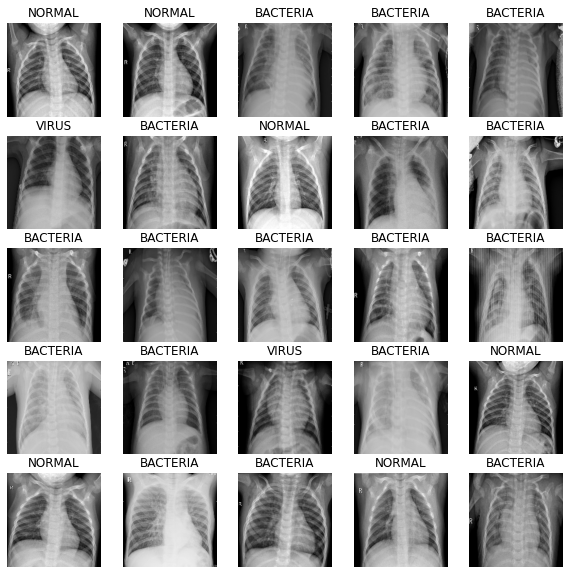

In [18]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Model Building

In [19]:
# Init the VGG model
vgg_conv = vgg16.VGG16(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3))

# Check the trainable status of the individual layers
'''
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
'''
'''
for layer in vgg_conv.layers[10:]:#[:-4]:
    print(layer, len(layer.get_weights()))
    
    if len(layer.get_weights()) > 0:
        #print(layer.get_weights()[1].shape)
        layer.set_weights([
            np.random.normal(loc=0.0, scale=0.01, size=layer.get_weights()[0].shape),
            np.zeros(shape=layer.get_weights()[1].shape),
            ])

for layer in vgg_conv.layers:
    print(layer, layer.trainable)
'''
# Create the model
model = Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              13108224  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 27,830,083
Trainable params: 27,828,035
Non-trainable params: 2,048
________________________________________

In [20]:
## weigh each class according to the imbalance
## The idea is to multiply the loss with the weight, so the model focus more on the class that has a
## larger weight than a class with a smaller weight
## for loss weighting and focal loss, please refer to
## Ref: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_BACTERIA)*(TRAIN_IMG_COUNT)/2.0
weight_for_2 = (1 / COUNT_VIRUS)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.93
Weight for class 1: 1.03
Weight for class 2: 1.95


In [21]:
## use accuracy, precision and recall to monitor the model train val performances
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

## since this is a binary classification problem, we can use the binary cross entropy loss function
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [22]:
# ## Train the model
# history = model.fit(
#     train_ds,
#     steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#     class_weight=class_weight,
# )



In [23]:
## save the best model using checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)
## To prevent the model from becoming worst (e.g. overfitting) stop the training before the issues start using the Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [24]:
## Decay the learning rate throught the training so the updates will gradually take smaller steps than at the begining.
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        ## scale the initial learning rate by an exponential function 0.1^(e/s)
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)



In [25]:


history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, lr_scheduler]
)



- accuracy: 0.7764 - precision: 0.7856 - recall: 0.7639 - val_loss: 1.8827 - val_accuracy: 0.2549 - val_precision: 0.2549 - val_recall: 0.2551
Epoch 14/100
32/32 [==============================] - 20s 639ms/step - loss: 0.6764 - accuracy: 0.7817 - precision: 0.7882 - recall: 0.7688 - val_loss: 31542912.0000 - val_accuracy: 0.5527 - val_precision: 0.5521 - val_recall: 0.5494
Epoch 15/100
32/32 [==============================] - 22s 677ms/step - loss: 0.6740 - accuracy: 0.7734 - precision: 0.7776 - recall: 0.7615 - val_loss: 3.2278 - val_accuracy: 0.4893 - val_precision: 0.4893 - val_recall: 0.4897
Epoch 16/100
32/32 [==============================] - 21s 667ms/step - loss: 0.6586 - accuracy: 0.7893 - precision: 0.7974 - recall: 0.7793 - val_loss: 256808800.0000 - val_accuracy: 0.4854 - val_precision: 0.4854 - val_recall: 0.4858
Epoch 17/100
32/32 [==============================] - 21s 669ms/step - loss: 0.6667 - accuracy: 0.7725 - precision: 0.7794 - recall: 0.7649 - val_loss: 17347170.

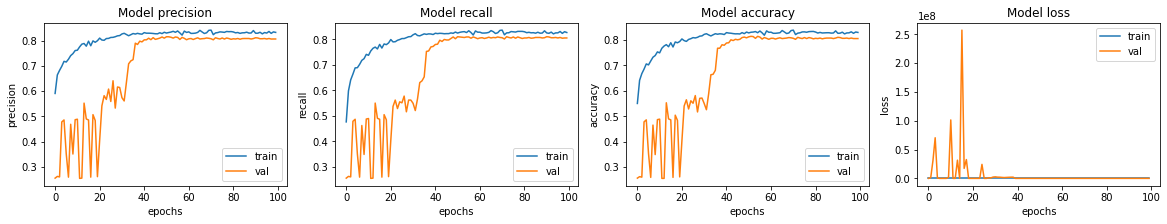

In [26]:
## visualize the performance
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
fig.savefig("./plots/mult_vgg_all_random.png")